In [18]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# visualization
import matplotlib.pyplot as plt

In [19]:
train_data, test_data, val_data, train_labels, test_labels, val_labels, test_true_labels = utility.preprocess_data()

In [20]:
# data shape
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

# labels shape
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)
print(test_true_labels.shape)

(20700, 784)
(6900, 784)
(6900, 784)
(20700,)
(6900,)
(6900,)
(6900,)


Dataset split: 20700 train rows
Dataset split: 20700 test rows


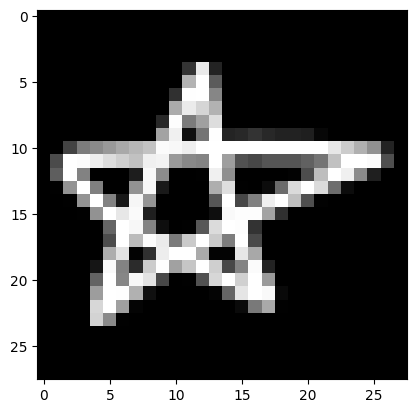

In [21]:
print(f"Dataset split: {len(train_data)} train rows")
print(f"Dataset split: {len(train_labels)} test rows")

point = train_data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [22]:
latent_dim = 2

In [23]:
# encoder
vae_input = Input(shape=(784,))
x = Dense(256, activation='relu')(vae_input)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [24]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [25]:
z = Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [26]:
# decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(decoder_input)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(784, activation='sigmoid')(x)
decoded = x

In [27]:
# Encoder model
encoder = Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = Model(inputs=decoder_input, outputs=decoded)

In [28]:
vae_output = decoder(encoder(vae_input)[2])
vae = Model(inputs=vae_input, outputs=vae_output)

In [29]:
def vae_loss(x, x_decoded_mean):
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
    vae_loss = reconstruction_loss + kl_loss
    return vae_loss

vae.add_loss(vae_loss(vae_input, vae_output))

In [30]:
vae.compile(optimizer='adam')

In [31]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = vae.fit(train_data, train_data, epochs=100, batch_size=512, shuffle=True,
                          validation_data=(val_data, val_data), callbacks=[early_stopping])

Epoch 1/100


41/41 [==============================] - 2s 19ms/step - loss: 0.1604 - val_loss: 0.1008
Epoch 2/100
41/41 [==============================] - 1s 17ms/step - loss: 0.0982 - val_loss: 0.0961
Epoch 3/100
41/41 [==============================] - 1s 16ms/step - loss: 0.0958 - val_loss: 0.0950
Epoch 4/100
41/41 [==============================] - 1s 17ms/step - loss: 0.0949 - val_loss: 0.0942
Epoch 5/100
41/41 [==============================] - 1s 17ms/step - loss: 0.0942 - val_loss: 0.0937
Epoch 6/100
41/41 [==============================] - 1s 17ms/step - loss: 0.0938 - val_loss: 0.0934
Epoch 7/100
41/41 [==============================] - 1s 17ms/step - loss: 0.0936 - val_loss: 0.0933
Epoch 8/100
41/41 [==============================] - 1s 16ms/step - loss: 0.0935 - val_loss: 0.0932
Epoch 9/100
41/41 [==============================] - 1s 16ms/step - loss: 0.0934 - val_loss: 0.0932
Epoch 10/100
41/41 [==============================] - 1s 16ms/step - loss: 0.0935 - val_loss: 0.0932
Epoch 11/10

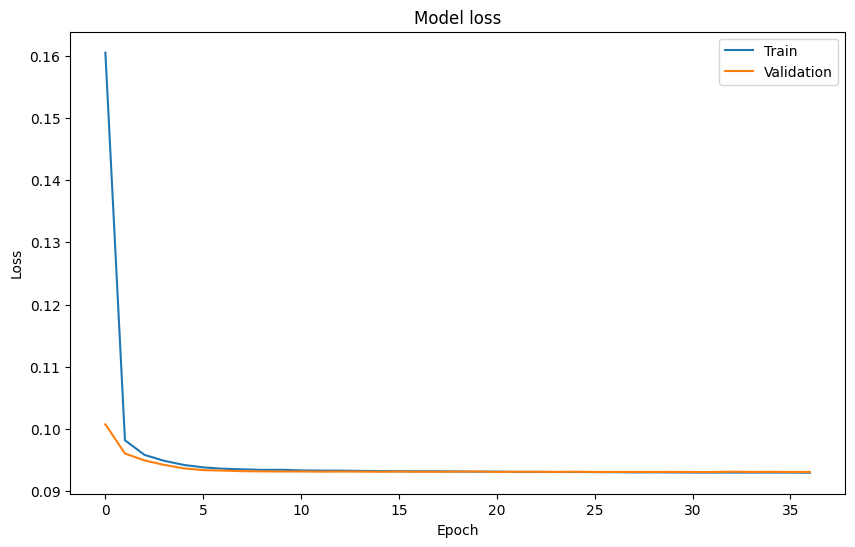

In [32]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

647/647 [==============================] - 2s 2ms/step


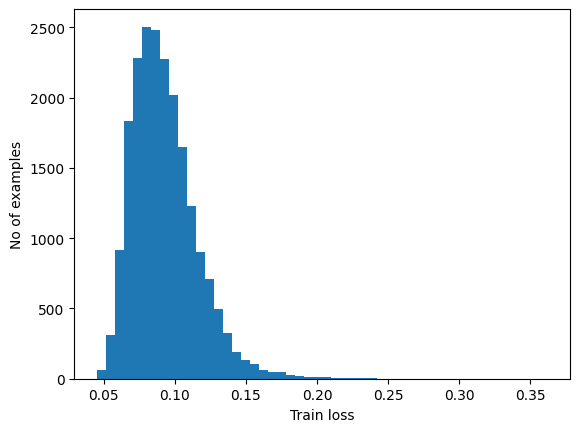

In [33]:
reconstructions = vae.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [34]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold)

# Choose a quantile (e.g., 99th percentile) for the threshold
threshold = np.percentile(train_loss, 99)
print("Quantile Threshold ", threshold)

Threshold  0.116023935
Quantile Threshold  0.16554467171430587


In [35]:
preds, loss, proba = utility.predict(vae, test_data, threshold)

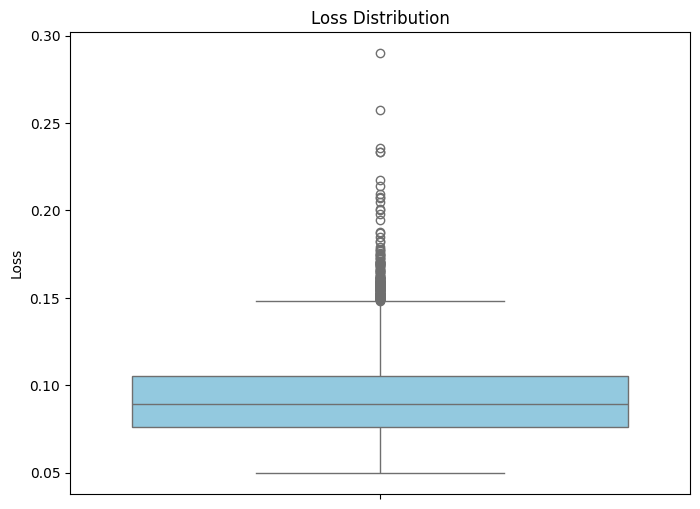

In [36]:
utility.boxplot_plot("Loss", loss)

C:\Users\zippe\AppData\Local\Temp\ipykernel_23328\1046356683.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')


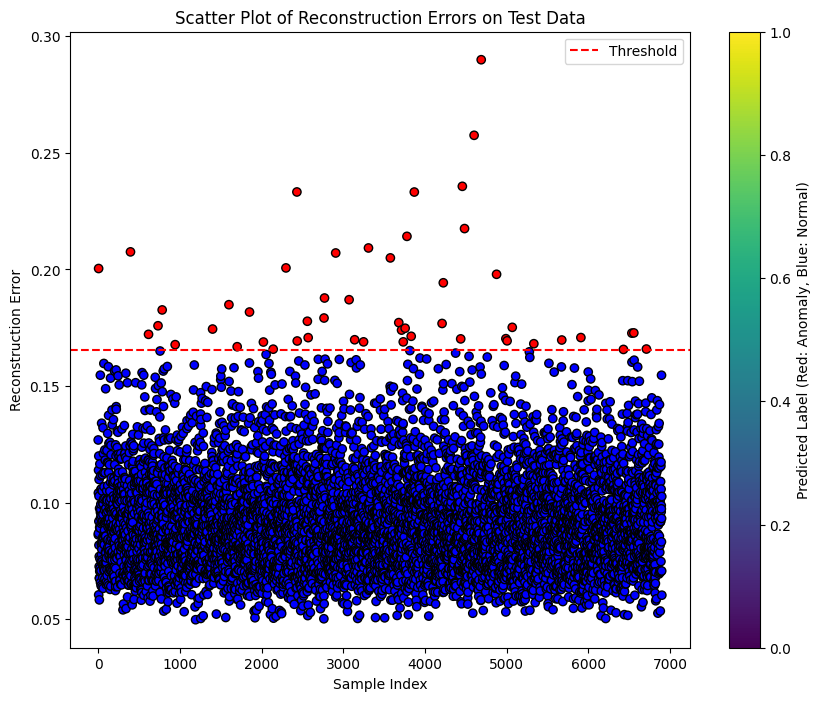

In [37]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(loss > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [38]:
a, p, r, report, cm = utility.get_metrics(preds, test_true_labels)

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [39]:
utility.print_stats(a, p, r, report, cm)

Accuracy = 0.9927536231884058
Precision = 1.0
Recall = 0.9927536231884058
Report
               precision    recall  f1-score   support

     anomaly       0.00      0.00      0.00         0
      normal       1.00      0.99      1.00      6900

    accuracy                           0.99      6900
   macro avg       0.50      0.50      0.50      6900
weighted avg       1.00      0.99      1.00      6900

Confusion Matrix
[[   0    0]
 [  50 6850]]


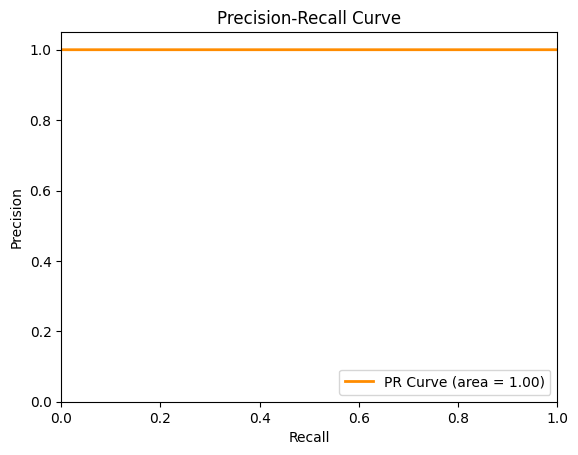

In [40]:
utility.pr_auc_plot(proba, test_true_labels)

In [41]:
utility.roc_plot(preds, test_true_labels)

Only one class present in y_true. ROC AUC score is not defined in that case.


True Negatives: 0
False Positives: 0
False Negatives: 50
True Positives: 6850


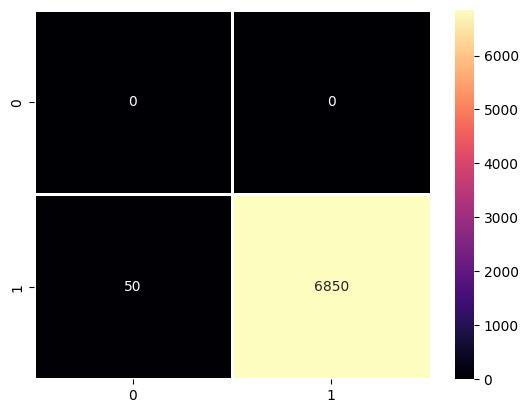

In [42]:
utility.create_heatmap(cm)

In [43]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


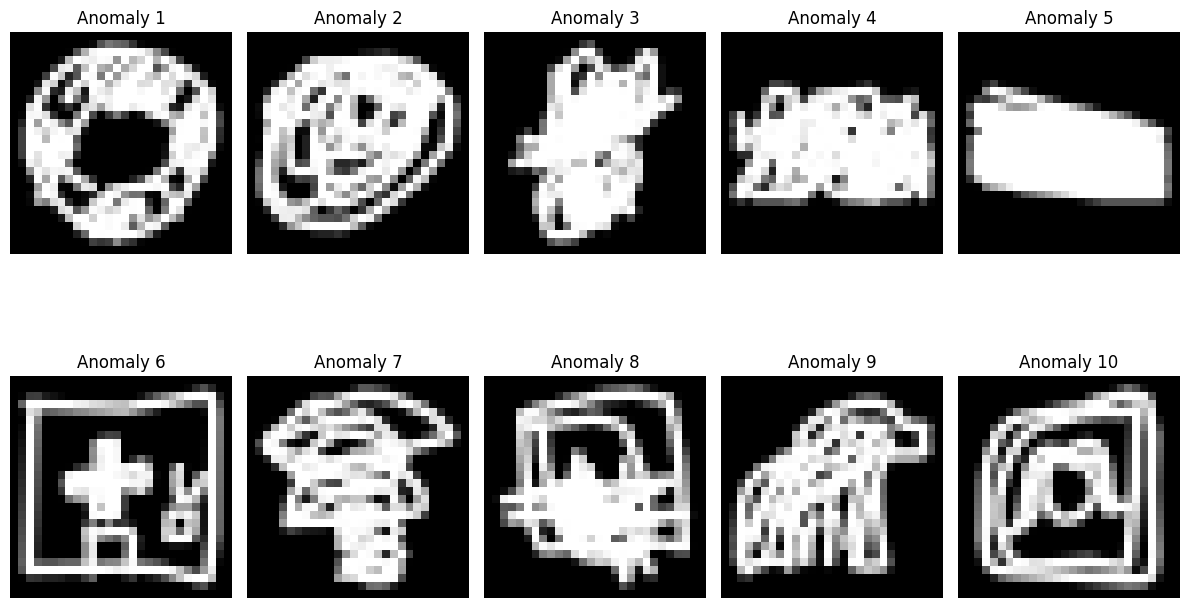

In [44]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data)